# Hyeyoung Sim: Clustering Electric Vehicle Charging Pattern with DTW and EV Charging energy demand Prediction with LSTM
[Presentation](http://spatial-ecology.net/docs/source/STUDENTSPROJECTS/Proj_2022_Matera/Clustering_Electric_Vehicle_Charging_Pattern_with_DTW_and_EV_Charging_energy_demand_Prediction_with_LSTM_Hyeyoung_Sim.pdf)
[Video recording](https://youtu.be/-PGvRM6hVtM)

In [246]:
# !pip install dtw-python
# !pip install numpy
# !pip install pandas
# !pip install time
# !pip install datetime
# !pip install openpyxl
# !pip install tensorflow
# !pip install seaborn
# !pip install sklearn
# !pip install keras
# !pip install shap

In [1]:
import time
from datetime import datetime
import numpy as np
import dtw
import pandas as pd
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



2022-06-17 03:50:12.753342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-17 03:50:12.753381: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(os.getcwd())

/media/sf_LVM_shared/tmpp


In [3]:
# print(os.path.realpath('21_keco.xlsx'))
# base_dir = '/media/sf_LVM_shared/tmpp'
# excel_file = '21_keco.xlsx'
# excel_dir = os.path.join(base_dir, excel_file)

# a = pd.read_excel(excel_dir, sheet_name = '21_1')
# a2 = pd.read_excel(excel_dir, sheet_name = '21_2')
# a3 = pd.read_excel(excel_dir, sheet_name = '21_3')
# a4 = pd.read_excel(excel_dir, sheet_name = '21_4')
# a5 = pd.read_excel(excel_dir, sheet_name = '21_5')
# a6 = pd.read_excel(excel_dir, sheet_name = '21_6')
# a7 = pd.read_excel(excel_dir, sheet_name = '21_7')
# a8 = pd.read_excel(excel_dir, sheet_name = '21_8')
# a9 = pd.read_excel(excel_dir, sheet_name = '21_9')
# a10 = pd.read_excel(excel_dir, sheet_name = '21_10')
# a11 = pd.read_excel(excel_dir, sheet_name = '21_11')
# a12 = pd.read_excel(excel_dir, sheet_name = '21_12')

In [4]:
a1 = pd.read_table('/media/sf_LVM_shared/tmpp/18_keco.txt' , sep = "/")
a2 = pd.read_table('/media/sf_LVM_shared/tmpp/19_keco.txt' , sep = "/")
a3 = pd.read_table('/media/sf_LVM_shared/tmpp/20_keco.txt' , sep = "/")
a4 = pd.read_table('/media/sf_LVM_shared/tmpp/21_keco.txt' , sep = ":")
a5 = pd.read_table('/media/sf_LVM_shared/tmpp/22_keco.txt' , sep = "/")

In [5]:
print(a1.columns)
print(a2.columns)
print(a3.columns)
print(a4.columns)
print(a5.columns)

Index(['dc', 'CNM', 'add', 'Max.vol', 'acvol', 'diffhour', 'starttm', 'endtm'], dtype='object')
Index(['dc', 'CNM', 'add', 'Max.vol', 'acvol', 'diffhour', 'starttm', 'endtm'], dtype='object')
Index(['dc', 'CNM', 'add', 'Max.vol', 'acvol', 'diffhour', 'starttm', 'endtm'], dtype='object')
Index(['type', 'dc', 'CNM', 'add', 'Max.vol', 'acvol', 'diffhour', 'diffmin',
       'starttm', 'endtm'],
      dtype='object')
Index(['type', 'dc', 'CNM', 'add', 'Max.vol', 'acvol', 'diffhour', 'diffmin',
       'starttm', 'endtm'],
      dtype='object')


In [6]:
a1 = a1[['CNM', 'add', 'Max.vol', 'acvol', 'starttm', 'endtm']]
a2 = a2[['CNM', 'add', 'Max.vol', 'acvol', 'starttm', 'endtm']]
a3 = a3[['CNM', 'add', 'Max.vol', 'acvol', 'starttm', 'endtm']]
a4 = a4[['CNM', 'add', 'Max.vol', 'acvol', 'starttm', 'endtm']]
a5 = a5[['CNM', 'add', 'Max.vol', 'acvol', 'starttm', 'endtm']]

In [7]:
c = pd.concat([a1,a2,a3,a4,a5])
c.shape

(855137, 6)

In [8]:
c.dtypes

CNM         object
add         object
Max.vol      int64
acvol      float64
starttm      int64
endtm        int64
dtype: object

In [11]:
c['start'] = c['starttm'].astype(str)
c['end'] = c['endtm'].astype(str)

In [13]:
c['start'] = pd.to_datetime(c['start'])
c['start'] = c['start'].dt.tz_localize('Asia/Seoul')
print(c['start'])

1        2018-01-01 00:17:16+09:00
2        2018-01-01 00:35:24+09:00
3        2018-01-01 00:59:13+09:00
4        2018-01-01 01:06:31+09:00
5        2018-01-01 01:24:24+09:00
                    ...           
125453   2022-03-30 16:22:47+09:00
125454   2022-03-30 16:32:43+09:00
125455   2022-03-30 16:38:09+09:00
125456   2022-03-30 16:30:22+09:00
125457   2022-03-30 16:27:55+09:00
Name: start, Length: 855137, dtype: datetime64[ns, Asia/Seoul]


In [14]:
c['endsec'] =c['end'].str.slice(12,14)

In [15]:
c['endsec'] = pd.to_numeric(c['endsec'], errors = 'coerce')
c = c[c.endsec <=59]

In [16]:
c['endmin'] = c['end'].str.slice(10,12) #min <=59
c['endmin'] = pd.to_numeric(c['endmin'], errors = 'coerce')
c = c[c.endmin <=59]

c['end'] = pd.to_datetime(c['end'])
c['end'] = c['end'].dt.tz_localize('Asia/Seoul')
print(c['end'])

1        2018-01-01 00:54:56+09:00
2        2018-01-01 01:09:26+09:00
3        2018-01-01 01:22:13+09:00
4        2018-01-01 01:36:11+09:00
5        2018-01-01 01:35:49+09:00
                    ...           
125453   2022-03-30 16:42:32+09:00
125454   2022-03-30 17:13:06+09:00
125455   2022-03-30 17:13:47+09:00
125456   2022-03-30 17:10:22+09:00
125457   2022-03-30 17:07:55+09:00
Name: end, Length: 851558, dtype: datetime64[ns, Asia/Seoul]


In [17]:
c['date_time']= c.start.dt.to_period('H')

/home/user/SE_data/juplab_env/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [18]:
c['SIG'] = c['add'].str.slice(6,9)

In [19]:
# print(c.isnull().sum())
print(c['Max.vol'].max())
print(c['Max.vol'].min())

200
50


In [20]:
from datetime import datetime
c['diff'] = (c['end'] - c['start'])
c['difhour'] = c['diff'].dt.seconds
c['diff'].head()

1   0 days 00:37:40
2   0 days 00:34:02
3   0 days 00:23:00
4   0 days 00:29:40
5   0 days 00:11:25
Name: diff, dtype: timedelta64[ns]

In [21]:
c['difhour'].head()

1    2260
2    2042
3    1380
4    1780
5     685
Name: difhour, dtype: int64

In [22]:
c['difhour'] = c['difhour']/3600
c['difhour'].head()

1    0.627778
2    0.567222
3    0.383333
4    0.494444
5    0.190278
Name: difhour, dtype: float64

In [23]:
c['log_date'] = c['start'].dt.date
c['log_hour']=c['start'].dt.hour
# # print(c['start'].strftime("%c"))
# print(c['log_date'])
# print(c['log_hour'])
# # c['date_time'] = 

In [24]:
c['volh'] = c['acvol']/c['difhour']
c['outlier'] = np.where( c['volh']<= c['Max.vol'], 'ok', 'no')
c2 = c[c['outlier'] == 'ok']
print(len(c))
print(len(c2))

851558
850664


In [25]:
# min hour/ max hour
c2 = c2[(c2['difhour'] >= 0.083333)&(c2['difhour'] <= 24) ]  #5/60 = 0.08333
print(len(c2))
print(c2['difhour'].max())
print(c2['difhour'].min())

827489
23.988333333333333
0.08333333333333333


In [26]:
c2['year'] = c2['start'].dt.year
c2['month'] = c2['start'].dt.month
c2['day'] = c2['start'].dt.day

In [27]:
c2['dateint'] = c2['year']*10000 + c2['month']*100 + c2['day'] + c2['log_hour']/24
print(c2.dateint.head())

1    2.018010e+07
2    2.018010e+07
3    2.018010e+07
4    2.018010e+07
5    2.018010e+07
Name: dateint, dtype: float64


In [28]:
c2.columns

Index(['CNM', 'add', 'Max.vol', 'acvol', 'starttm', 'endtm', 'start', 'end',
       'endsec', 'endmin', 'date_time', 'SIG', 'diff', 'difhour', 'log_date',
       'log_hour', 'volh', 'outlier', 'year', 'month', 'day', 'dateint'],
      dtype='object')

In [29]:
df= c2.drop(['add','Max.vol', 'acvol', 'starttm', 'endtm', 'end', 'diff', 'outlier'], axis=1)

In [30]:
print(len(df['SIG'].unique()))
print(df.head())               #FINAL DATA

25
            CNM                     start  endsec  endmin         date_time  \
1  볏골공원 지하공영주차장 2018-01-01 00:17:16+09:00    56.0      54  2018-01-01 00:00   
2           노보텔 2018-01-01 00:35:24+09:00    26.0       9  2018-01-01 00:00   
3      종묘 공영주차장 2018-01-01 00:59:13+09:00    13.0      22  2018-01-01 00:00   
4  현대블루핸즈 대치북부점 2018-01-01 01:06:31+09:00    11.0      36  2018-01-01 01:00   
5           노보텔 2018-01-01 01:24:24+09:00    49.0      35  2018-01-01 01:00   

   SIG   difhour    log_date  log_hour       volh  year  month  day  \
1  강서구  0.627778  2018-01-01         0  37.529204  2018      1    1   
2  강남구  0.567222  2018-01-01         0  26.515181  2018      1    1   
3  종로구  0.383333  2018-01-01         0  36.652174  2018      1    1   
4  강남구  0.494444  2018-01-01         1  41.420225  2018      1    1   
5  강남구  0.190278  2018-01-01         1  36.367883  2018      1    1   

        dateint  
1  2.018010e+07  
2  2.018010e+07  
3  2.018010e+07  
4  2.018010e+07  
5  2.

In [31]:
# df = c2.groupby(["SIG", "log_date", "log_hour"])['volh'].mean().reset_index()
df_datetime = df.groupby(["SIG", "date_time"])['volh'].mean().reset_index()
df_datetime.head()

,SIG,date_time,volh
0,강남구,2018-01-01 00:00,26.515181
1,강남구,2018-01-01 01:00,32.737450
2,강남구,2018-01-01 02:00,28.364020
3,강남구,2018-01-01 05:00,30.652220
4,강남구,2018-01-01 06:00,32.791086


In [32]:
##only for gn
df_datetime_gn = df_datetime[(df_datetime['SIG'] == '강남구')]
len(df_datetime_gn)

25718

###Daily EV charging 

In [35]:
df.SIG.unique()

array(['강서구', '강남구', '종로구', '광진구', '서초구', '영등포', '구로구', '강동구', '마포구',
       '관악구', '송파구', '은평구', '성북구', '용산구', '동대문', '노원구', '서대문', '성동구',
       '중구 ', '중랑구', '양천구', '동작구', '강북구', '금천구', '도봉구'], dtype=object)

In [36]:
df_logdate = df.groupby(["SIG", "log_date"])['volh'].mean().reset_index()
df_logdate.head()
##only for gn
df_logdate_gn = df_logdate[(df_logdate['SIG'] == '강남구')]
dataframe= df_logdate_gn.drop(['SIG', 'log_date'], axis=1)

dataset = dataframe.values
dataset = dataset.astype('float32')

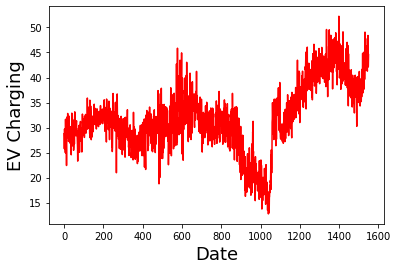

In [37]:
# #plotting the data
# plt.figure(figsize=(16,8))
# plt.title('Close Price History')
plt.plot(dataframe['volh'], color='red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('EV Charging', fontsize = 18)
plt.show()

In [38]:
# normalize the dataset
print(dataset.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

(1551, 1)


In [39]:
# split into train and test sets
print('len(dataset): ',len(dataset))
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

len(dataset):  1551
1039 512


In [40]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [41]:
## Let's train the LSTM using SGD as optimizer
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('testX.shape: ',testX.shape)
print('trainX[:5]: ', trainX[:5,:,:].flatten())
print('trainY[:5]: ', trainY[:5])


# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # hidden layer with 4 LSTM blocks or neurons, with time_step=1 and features=1.
model.add(Dense(1)) # output layer that makes a single value prediction

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.SGD(learning_rate=0.01))

# Fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

trainX.shape:  (1037, 1, 1)
trainY.shape:  (1037,)
testX.shape:  (510, 1, 1)
trainX[:5]:  [0.40584978 0.32951364 0.42946067 0.386174   0.4079348 ]
trainY[:5]:  [0.32951364 0.42946067 0.386174   0.4079348  0.40748814]


2022-06-17 03:53:21.742617: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-17 03:53:21.742648: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-17 03:53:21.742677: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (osgeolive): /proc/driver/nvidia/version does not exist
2022-06-17 03:53:21.748407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 227.62951803207397 seconds ---


In [42]:
# summarize history for loss
def plot_hist(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','val'], loc='upper left')
    plt.show()

# make predictions
def make_preds(trainX,trainY,testX,testY):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

    return trainPredict, testPredict

# shift train predictions for plotting
def plot_preds(trainPredict,testPredict):
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

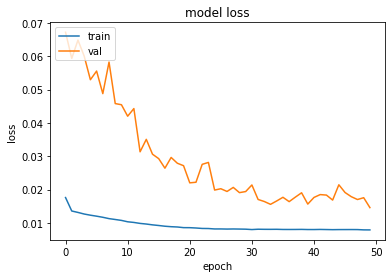

In [43]:
plot_hist(history)

In [44]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

16/16 [==============================] - 0s 2ms/step
Train Score: 3.57 RMSE
Train R^2:  0.43751046016410977
Test Score: 4.77 RMSE
Test R^2:  0.43999636627656


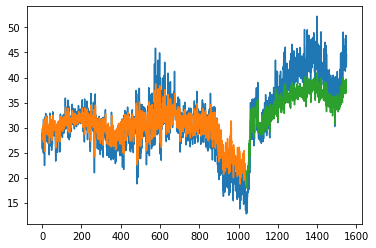

In [45]:
plot_preds(trainPredict,testPredict)

In [46]:
# Let's redo it using ADAM 7;51
# reshape into X=t and Y=t+1
look_back = 1
# our data is in the form: [samples, features]
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: ', trainX[:5,:,:].flatten())
print('trainY[:5]: ', trainY[:5])

# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1)) 

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))

# Fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

trainX.shape:  (1037, 1, 1)
trainY.shape:  (1037,)
trainX[:5]:  [0.40584978 0.32951364 0.42946067 0.386174   0.4079348 ]
trainY[:5]:  [0.32951364 0.42946067 0.386174   0.4079348  0.40748814]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 264.29672741889954 seconds ---


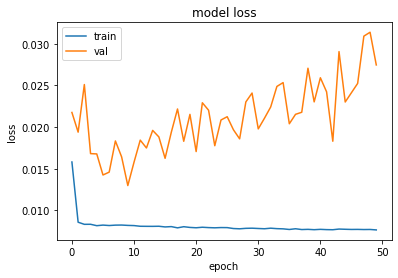

In [47]:
plot_hist(history)

In [48]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

16/16 [==============================] - 0s 3ms/step
Train Score: 3.43 RMSE
Train R^2:  0.4824621484663243
Test Score: 6.54 RMSE
Test R^2:  -0.05321232523693742


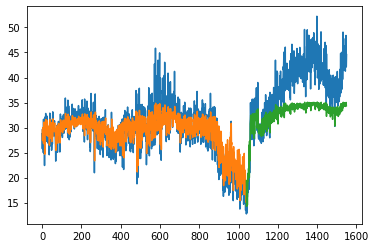

In [49]:
plot_preds(trainPredict,testPredict)

In [50]:
## LSTM for Regression Using the Window Method

In [51]:
 # reshape into X=t and Y=t+3
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: \n', trainX[:5])
print('trainY[:5]: \n', trainY[:5])

trainX.shape:  (1035, 3)
trainY.shape:  (1035,)
trainX[:5]: 
 [[0.40584978 0.32951364 0.42946067]
 [0.32951364 0.42946067 0.386174  ]
 [0.42946067 0.386174   0.4079348 ]
 [0.386174   0.4079348  0.40748814]
 [0.4079348  0.40748814 0.30990687]]
trainY[:5]: 
 [0.386174   0.4079348  0.40748814 0.30990687 0.47879067]


In [52]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: \n', trainX[:5])
print('trainY[:5]: \n', trainY[:5])

# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

trainX.shape:  (1035, 1, 3)
trainY.shape:  (1035,)
trainX[:5]: 
 [[[0.40584978 0.32951364 0.42946067]]

 [[0.32951364 0.42946067 0.386174  ]]

 [[0.42946067 0.386174   0.4079348 ]]

 [[0.386174   0.4079348  0.40748814]]

 [[0.4079348  0.40748814 0.30990687]]]
trainY[:5]: 
 [0.386174   0.4079348  0.40748814 0.30990687 0.47879067]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 247.12511897087097 seconds ---


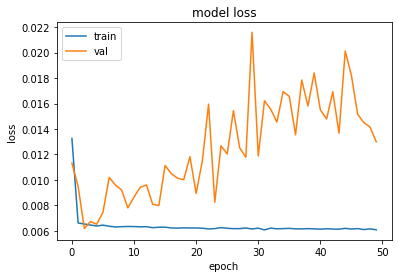

In [53]:
plot_hist(history)

In [54]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

16/16 [==============================] - 0s 3ms/step
Train Score: 3.13 RMSE
Train R^2:  0.5677213355887494
Test Score: 4.50 RMSE
Test R^2:  0.476461149770418


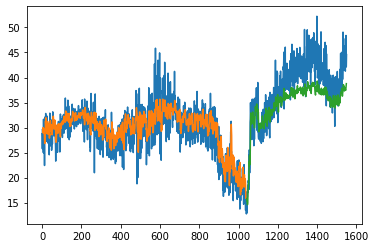

In [55]:
plot_preds(trainPredict,testPredict)

In [56]:
## LSTM for Regression with Time Steps
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: \n', trainX[:5])
print('trainY[:5]: \n', trainY[:5])

# create and fit the LSTM network
if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1))) # with time_step=3 and 1 feature.
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0, validation_data=(testX, testY))
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

trainX.shape:  (1035, 3, 1)
trainY.shape:  (1035,)
trainX[:5]: 
 [[[0.40584978]
  [0.32951364]
  [0.42946067]]

 [[0.32951364]
  [0.42946067]
  [0.386174  ]]

 [[0.42946067]
  [0.386174  ]
  [0.4079348 ]]

 [[0.386174  ]
  [0.4079348 ]
  [0.40748814]]

 [[0.4079348 ]
  [0.40748814]
  [0.30990687]]]
trainY[:5]: 
 [0.386174   0.4079348  0.40748814 0.30990687 0.47879067]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 351.80383682250977 seconds ---


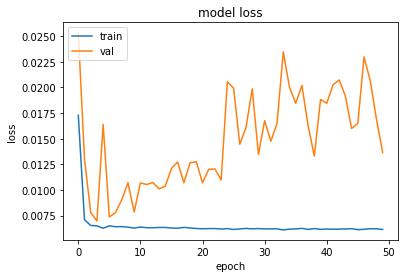

In [57]:
plot_hist(history)

In [58]:
trainPredict, testPredict = make_preds(trainX,trainY,testX,testY)

16/16 [==============================] - 0s 4ms/step
Train Score: 3.22 RMSE
Train R^2:  0.5431476837424603
Test Score: 4.61 RMSE
Test R^2:  0.45001772422963693


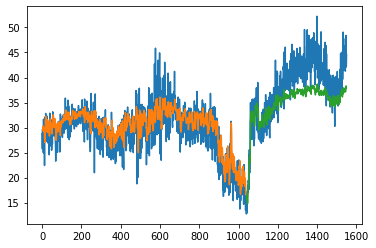

In [59]:
plot_preds(trainPredict,testPredict)

In [60]:
## LSTM with Memory Between Batches

In [69]:
# # reshape into X=t and Y=t+1
# look_back = 3
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)
# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# # create and fit the LSTM network
# batch_size = 1

# if 'model' in globals():
#     print('Deleting "model"')
#     del model
# model = Sequential()
# model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
# model.add(Dense(1))

# start_time = time.time()
# model.compile(loss='mean_squared_error', optimizer='adam')
# for i in range(100):
#     history = model.fit(trainX, trainY, epochs=50 , batch_size=batch_size, verbose=0, shuffle=False, validation_data=(testX, testY))
#     model.reset_states()
# print('keys: ',history.history.keys())
# print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

In [63]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

508/508 [==============================] - 1s 2ms/step
Train Score: 3.14 RMSE
Train R^2:  0.5653176934509332
Test Score: 7.81 RMSE
Test R^2:  -0.575034240837196


In [64]:
## Adding Early Stopping
# Using Early stopping
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
batch_size=1
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: ', trainX[:5].flatten())
print('trainY[:5]: ', trainY[:5])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('./models/best_model_LSTM.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size,1,look_back), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, 1,look_back), stateful=True))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1, validation_data=(testX, testY),callbacks=[es, mc])
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

# load the saved model
model = load_model('./models/best_model_LSTM.h5')

trainX.shape:  (1035, 1, 3)
trainY.shape:  (1035,)
trainX[:5]:  [0.40584978 0.32951364 0.42946067 0.32951364 0.42946067 0.386174
 0.42946067 0.386174   0.4079348  0.386174   0.4079348  0.40748814
 0.4079348  0.40748814 0.30990687]
trainY[:5]:  [0.386174   0.4079348  0.40748814 0.30990687 0.47879067]
Deleting "model"
Epoch 1/50
1025/1035 [============================>.] - ETA: 0s - loss: 0.0151
Epoch 1: val_loss improved from inf to 0.01571, saving model to ./models/best_model_LSTM.h5
1035/1035 [==============================] - 16s 10ms/step - loss: 0.0151 - val_loss: 0.0157
Epoch 2/50
1029/1035 [============================>.] - ETA: 0s - loss: 0.0095
Epoch 2: val_loss improved from 0.01571 to 0.00752, saving model to ./models/best_model_LSTM.h5
1035/1035 [==============================] - 10s 10ms/step - loss: 0.0094 - val_loss: 0.0075
Epoch 3/50
1027/1035 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 3: val_loss did not improve from 0.00752
1035/1035 [=============

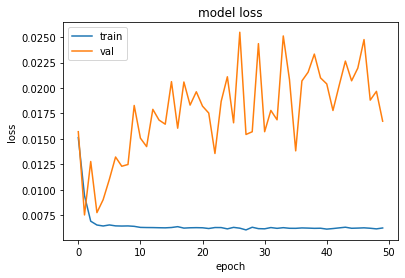

In [65]:
plot_hist(history)

508/508 [==============================] - 2s 3ms/step
Train Score: 3.16 RMSE
Train R^2:  0.5615679306120167
Test Score: 3.40 RMSE
Test R^2:  0.7020410118749283


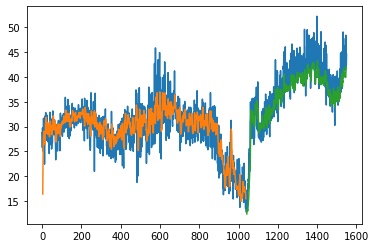

In [66]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore =  np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

trainX.shape:  (1035, 1, 3)
trainY.shape:  (1035,)
trainX[:5]:  [0.40584978 0.32951364 0.42946067 0.32951364 0.42946067 0.386174
 0.42946067 0.386174   0.4079348  0.386174   0.4079348  0.40748814
 0.4079348  0.40748814 0.30990687]
trainY[:5]:  [0.386174   0.4079348  0.40748814 0.30990687 0.47879067]
Deleting "model"
keys:  dict_keys(['loss', 'val_loss'])
--- Elapsed time: 319.7887361049652 seconds ---


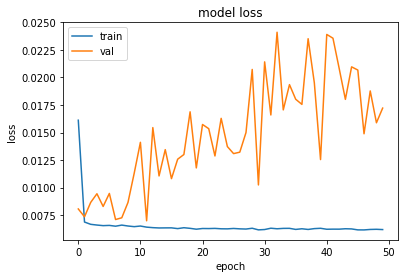

508/508 [==============================] - 2s 5ms/step
Train Score: 3.35 RMSE
Train R^2:  0.5055799253426811
Test Score: 3.30 RMSE
Test R^2:  0.7181920183273924


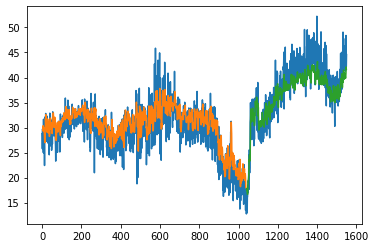

In [67]:
# Try more nodes in the LSTM
# Using Early stopping

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('trainX.shape: ',trainX.shape)
print('trainY.shape: ',trainY.shape)
print('trainX[:5]: ', trainX[:5].flatten())
print('trainY[:5]: ', trainY[:5])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=100)
mc = ModelCheckpoint('./models/best_model_LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

if 'model' in globals():
    print('Deleting "model"')
    del model
model = Sequential()
model.add(LSTM(8, batch_input_shape=(batch_size,1,look_back), return_sequences=True))
model.add(LSTM(8, batch_input_shape=(batch_size, 1,look_back)))
model.add(Dense(1))

start_time = time.time()
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0, validation_data=(testX, testY),callbacks=[es, mc])
# list all data in history
print('keys: ',history.history.keys())
print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

# load the saved model
model = load_model('./models/best_model_LSTM.h5')

plot_hist(history)

# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size) #Now we need to specify the batch_size
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: ', r2_score(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: ', r2_score(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
